In [1]:
from pathlib import Path
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import re

In [5]:
meta_fpath = "D:/ScalpData/JHU_scalp_clinical_datasheet_raw_local.xlsx"
root = Path("D:/ScalpData/detect_test/sourcedata")
json_fpaths = root.glob("*clip.json")
spike_rates = {}
for fpath in json_fpaths:
    subject = fpath.name.split("-")[0]
    with open(fpath) as f:
        rates = json.load(f)
    spike_rates[subject] = rates['total']
meta_df = pd.read_excel(meta_fpath)

In [6]:
meta_df

,patient_id,hospital_id,number_datasets,clinical_center,modality,montage,sfreq,"Group (0=non-epilepsy, 1=epilepsy-normal, 2=epilepsy-abnormal)",Ethnicity,"Race (0=caucasian, 1=african american, 2=hispanic, 3=asian)",...,hand,gender,bad_contacts,epilepsy_type (if applicable/known),imaging_outcome_notes,Date of Recording,Notes,include,Reason,best_window
0,101,1,1,jhh,scalp,standard 10-20,200,1,NaN,NaN,...,NaN,NaN,"Fz, Cz, E, X1-7, SpO2, EtCO2, DC03, DC04, DC05...",focal,NaN,NaN,"Lots of eye artifact. Pz looks more normal, bu...",Y,"Good after 100 s, remove Pz",100-400
1,201,2,1,jhh,scalp,standard 10-20,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,SHW',Y,Riddled with artifact,600-900
2,202,3,1,jhh,scalp,NaN,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",generalized,NaN,NaN,"PO3-4, PO7-8 are lower amplitude than rest. Al...",N,Something odd happened for the middle half of ...,NaN
3,203,4,1,jhh,scalp,NaN,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",focal,NaN,NaN,"Slow without SHW', a lot of movement/eye movem...",N,Maybe 2.5 minutes starting at 255 sec,NaN
4,204,5,1,jhh,scalp,NaN,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",focal,NaN,NaN,"PO7-8 ECG artifacts, Cz has very low amplitude...",Y,Good after 480 s,480-780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,126,82,1,jhh,scalp,standard 10-27,200,1,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,NaN,Y,NaN,0-300
82,228,83,2,jhh,scalp,standard 10-28,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,NaN,Y,NaN,0-300
83,127,84,2,jhh-bayview,scalp,standard 10-29,200,1,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,NaN,Y,NaN,0-300
84,229,85,1,jhh,scalp,standard 10-30,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,NaN,Y,NaN,0-300


In [7]:
subjects = spike_rates.keys()
rates = spike_rates.values()
ids = []
groups = []
for sub in subjects:
    sub_split = [s for s in re.findall(r"\d+", sub)]
    sub_int = sub_split[0]
    sub_row = meta_df.loc[meta_df['hospital_id'] == int(sub_int)]
    ptid = sub_row['patient_id'].item()
    ids.append(ptid)
    groups.append(sub_row['Group (0=non-epilepsy, 1=epilepsy-normal, 2=epilepsy-abnormal)'].item())
rate_df = pd.DataFrame()
rate_df['patient_id'] = ids
rate_df['hospital_id'] = subjects
rate_df['group'] = groups
rate_df['spike_rate (spikes/min*ch)'] = rates
rate_df['y'] = [g>1 for g in groups]

<AxesSubplot:title={'center':'spike_rate (spikes/min*ch)'}, xlabel='group'>

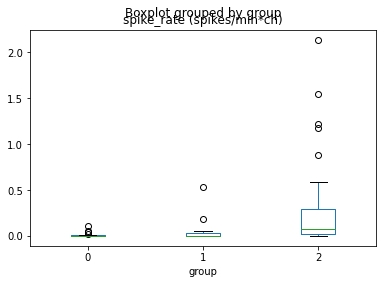

In [8]:
rate_df.boxplot('spike_rate (spikes/min*ch)', by='group', grid=False)

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(rate_df.drop(["y"], axis=1), rate_df["y"], test_size=1/len(subjects))
clf = SVC(kernel='rbf')
X = rate_df['spike_rate (spikes/min*ch)'].to_numpy().reshape(-1, 1)
y = rate_df["y"].to_numpy().astype(int)
clf.fit(X, y)
predictions = clf.predict(X)
print(clf.score(X, y))
[print(f"{real}: {predict} - {x[0]} - {ptid}") for real, predict, x, ptid in zip(y, predictions, X, ids)]

0.7934782608695652
0: 0 - 0.0 - 101
1: 1 - 2.140086206896552 - 205
0: 0 - 0.01664816870144284 - 3
0: 0 - 0.0 - 4
0: 0 - 0.010775862068965518 - 104
0: 0 - 0.0 - 105
0: 0 - 0.0 - 5
0: 0 - 0.03745837957824639 - 106
0: 0 - 0.010227272727272727 - 6
0: 0 - 0.03329633740288568 - 107
0: 0 - 0.049479166666666664 - 7
1: 0 - 0.09291377601585729 - 201
1: 1 - 0.340522133938706 - 206
0: 0 - 0.007352941176470588 - 8
0: 0 - 0.0 - 9
1: 0 - 0.031545741324921134 - 207
0: 0 - 0.0 - 10
0: 0 - 0.007804370447450573 - 108
0: 0 - 0.0 - 109
1: 0 - 0.015000000000000001 - 208
0: 1 - 0.5307825086306099 - 110
1: 0 - 0.06458094144661308 - 209
1: 0 - 0.08409785932721711 - 202
0: 0 - 0.0 - 111
0: 0 - 0.04679144385026738 - 11
1: 1 - 0.4877398720682303 - 210
0: 0 - 0.0 - 112
1: 0 - 0.02880184331797235 - 211
0: 0 - 0.0 - 12
0: 0 - 0.050713749060856496 - 113
0: 0 - 0.0 - 13
0: 0 - 0.0 - 14
0: 0 - 0.05172413793103449 - 114
1: 0 - 0.0 - 203
1: 1 - 0.1285282258064516 - 212
0: 0 - 0.0 - 15
1: 1 - 1.1736958934517203 - 213
0: 0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]